# Diamond Segmentation Pipeline

This notebook demonstrates the complete diamond segmentation pipeline using GrabCut algorithm with CLAHE preprocessing.

In [1]:
# Import required libraries
import sys
sys.path.append('..')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from src.data.loader import DiamondDataLoader, DiamondShapeMapper
from src.utils.segmentation import (
    init_grabcut_mask,
    preprocess_for_segmentation,
    remove_background,
    visualize_mask
)
from src.utils.visualization import (
    annotate_segmentation,
    create_comparison_grid,
    create_segmentation_pipeline_viz
)
from src.pipe.processor import DiamondProcessor

%matplotlib inline

## 1. Setup and Configuration

In [2]:
# Configure paths
OUTPUT_PATH = '../data/processed'
VARIANT = 'Shape_1d_256i'

# Initialize loader and mapper
loader = DiamondDataLoader(VARIANT)
mapper = DiamondShapeMapper()

print(f"Dataset: {VARIANT}")
print(f"Output directory: {OUTPUT_PATH}")

Dataset: Shape_1d_256i
Output directory: ../data/processed


## 2. Single Image Segmentation Demo

In [3]:
# Select a sample image
SHAPE_ID = 1  # Asscher
IMAGE_INDEX = 0

shape_code = mapper.get_shape_code(SHAPE_ID)
shape_name = mapper.get_shape_name(shape_code)

# Load image
images = loader.list_images(SHAPE_ID)
image_path = loader.get_image_path(SHAPE_ID, images[IMAGE_INDEX])
image = cv2.imread(image_path)

print(f"Processing: {shape_name} ({shape_code})")
print(f"Image shape: {image.shape}")

Processing: Asscher (AS)
Image shape: (600, 599, 3)


### 2.1 Visualize Original Image

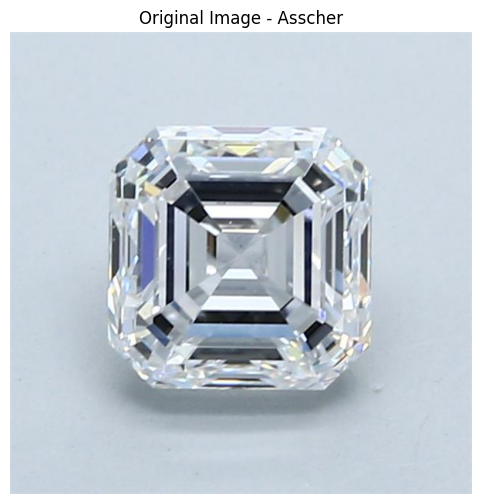

In [4]:
# Display original image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Original Image - {shape_name}')
plt.axis('off')
plt.show()

### 2.2 Preprocessing with CLAHE

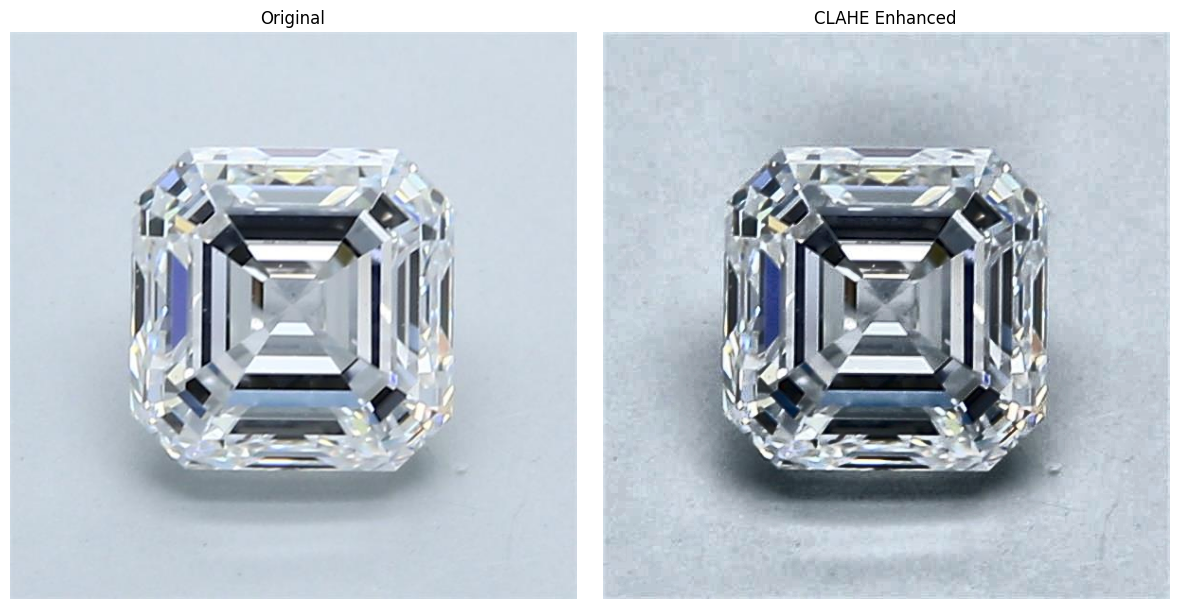

In [5]:
# Apply preprocessing
original, enhanced = preprocess_for_segmentation(image)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
axes[1].set_title('CLAHE Enhanced')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 2.3 Initialize GrabCut Mask

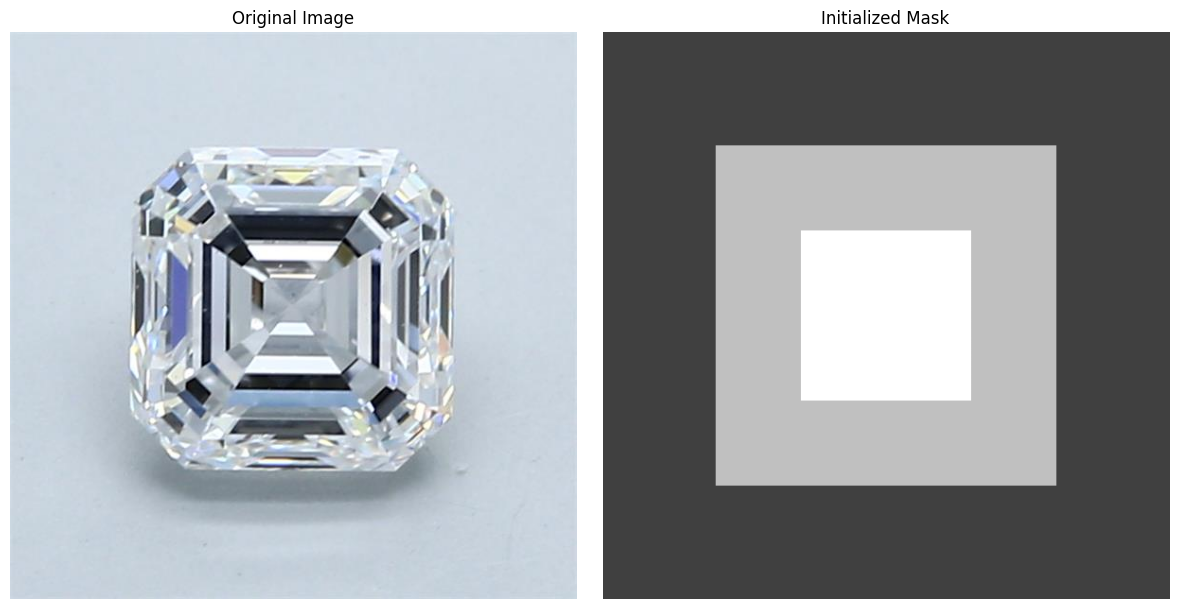

Mask Legend:
  Black: Definite Background
  Dark Gray: Probable Background
  Light Gray: Probable Foreground
  White: Definite Foreground


In [6]:
# Initialize mask
h, w = image.shape[:2]
mask = init_grabcut_mask(h, w)

# Visualize mask
mask_viz = visualize_mask(mask)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(mask_viz, cv2.COLOR_BGR2RGB))
axes[1].set_title('Initialized Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Mask Legend:")
print("  Black: Definite Background")
print("  Dark Gray: Probable Background")
print("  Light Gray: Probable Foreground")
print("  White: Definite Foreground")

### 2.4 Apply GrabCut Segmentation

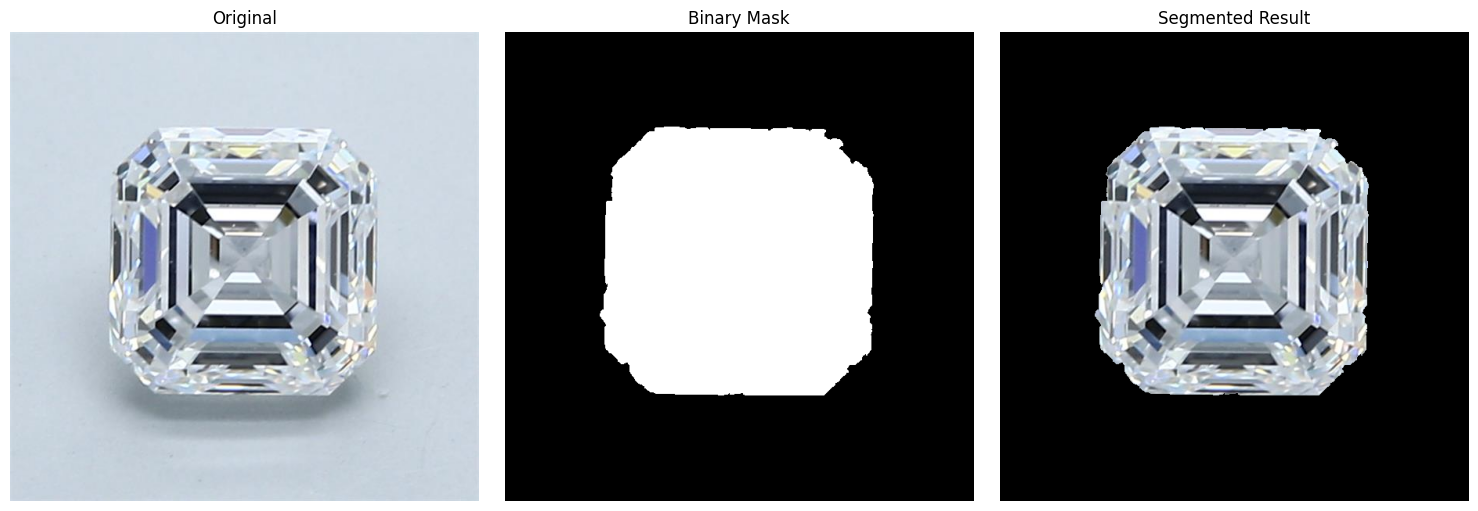

In [7]:
# Perform segmentation
segmented, binary_mask = remove_background(original, enhanced, iterations=5)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
axes[2].set_title('Segmented Result')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### 2.5 Add Annotations

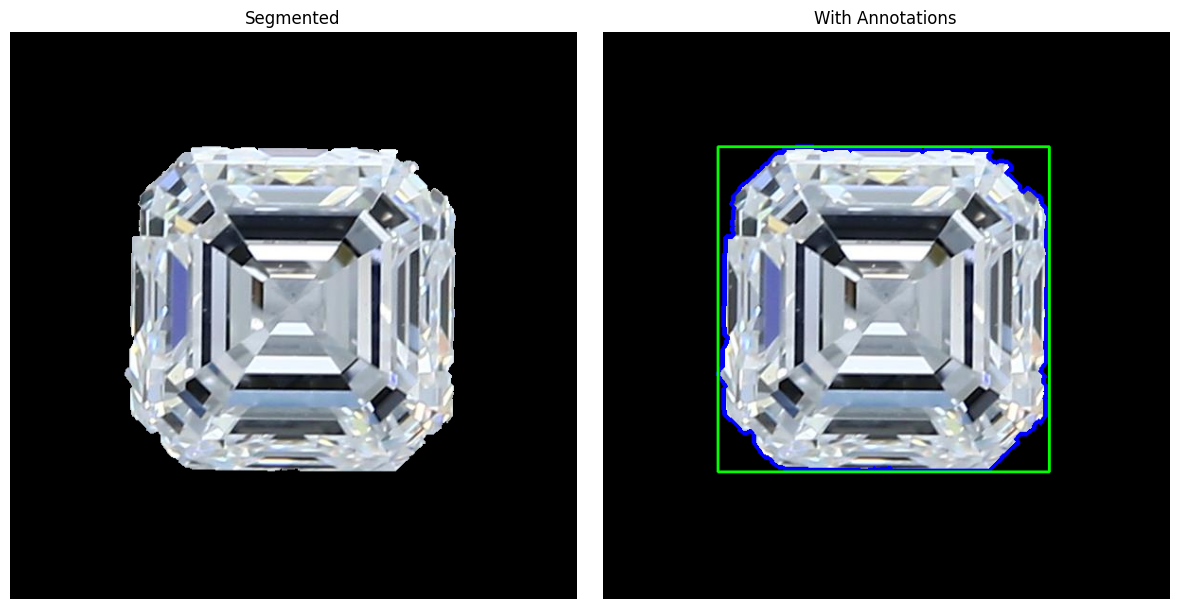

In [8]:
# Add contours and bounding box
annotated = annotate_segmentation(segmented, binary_mask)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
axes[0].set_title('Segmented')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
axes[1].set_title('With Annotations')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 2.6 Complete Pipeline Visualization

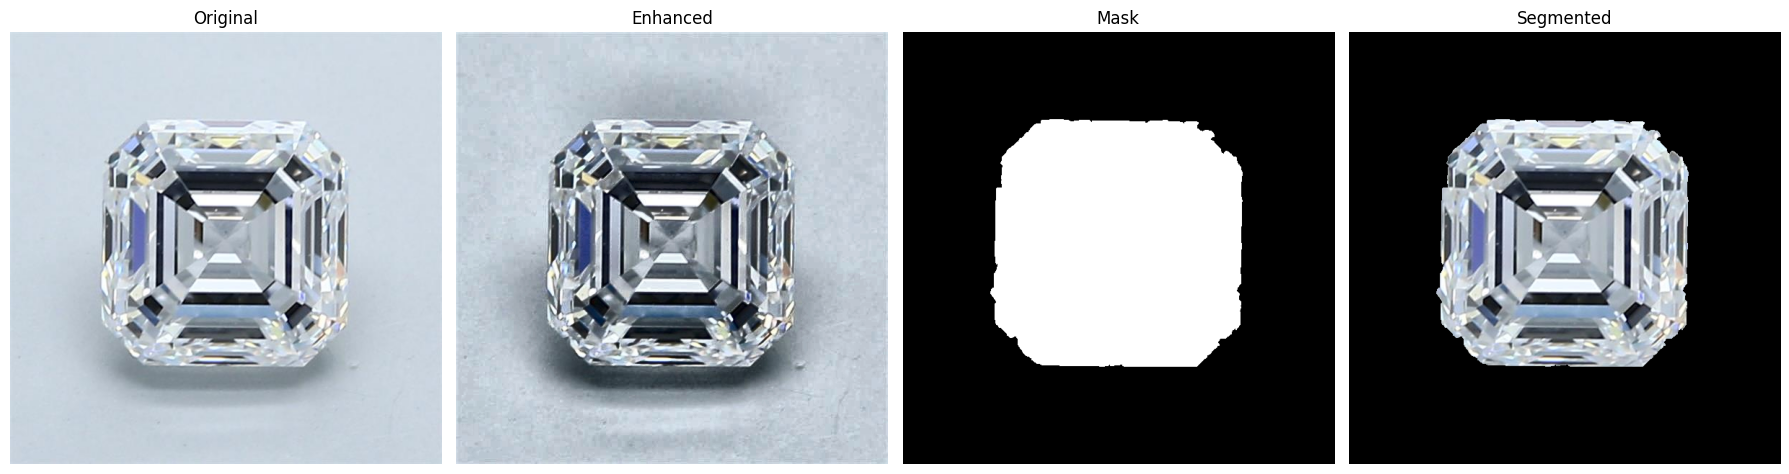

In [9]:
# Show complete pipeline
fig = create_segmentation_pipeline_viz(original, enhanced, binary_mask, segmented, figsize=(18, 5))
plt.show()

## 3. Batch Processing Demo

In [10]:
# Process multiple images from a shape category
NUM_IMAGES = 10
BATCH_SHAPE_ID = 2  # Brilliant

shape_code = mapper.get_shape_code(BATCH_SHAPE_ID)
shape_name = mapper.get_shape_name(shape_code)

print(f"Processing {NUM_IMAGES} images from {shape_name} ({shape_code})...")

Processing 10 images from Brilliant (BR)...


In [11]:
# Get image list
images = loader.list_images(BATCH_SHAPE_ID)
sample_images = images[:NUM_IMAGES]

# Process images
results = []

for img_name in tqdm(sample_images, desc="Processing"):
    img_path = loader.get_image_path(BATCH_SHAPE_ID, img_name)
    img = cv2.imread(img_path)
    
    # Preprocess and segment
    orig, enh = preprocess_for_segmentation(img)
    seg, mask = remove_background(orig, enh, iterations=5)
    
    results.append((orig, seg, mask))

print(f"Processed {len(results)} images successfully!")

Processing: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Processed 10 images successfully!


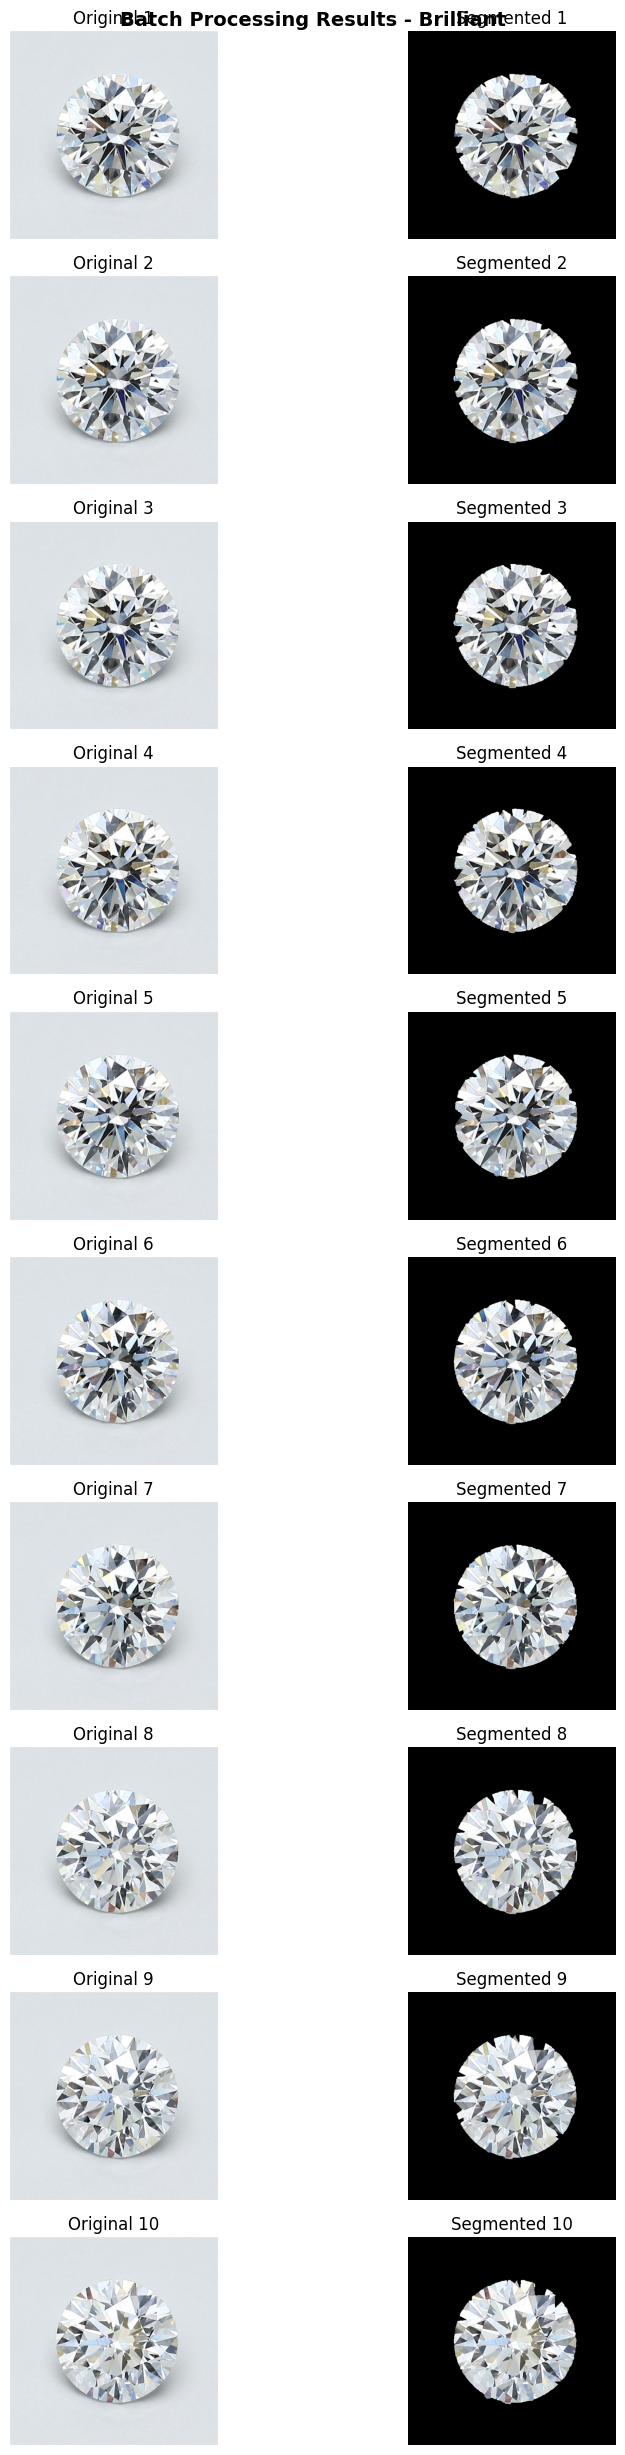

In [12]:
# Display grid of results
fig, axes = plt.subplots(NUM_IMAGES, 2, figsize=(10, NUM_IMAGES * 2.5))
fig.suptitle(f'Batch Processing Results - {shape_name}', fontsize=14, fontweight='bold')

for idx, (orig, seg, mask) in enumerate(results):
    axes[idx, 0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    axes[idx, 0].set_title(f'Original {idx+1}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
    axes[idx, 1].set_title(f'Segmented {idx+1}')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

## 4. Using DiamondProcessor

In [13]:
# Initialize processor
processor = DiamondProcessor(
    data_loader=loader,
    iterations=5,
    add_annotations=False
)

print("Processor initialized!")
print(f"Output directory: {processor.output_dir}")

Processor initialized!
Output directory: /Users/rushirbhavsar/Main/code/git-commits/diamond-shape-segmentation/notebooks/../src/data/processed


In [14]:
# Process a single shape category (limited images for demo)
DEMO_SHAPE_ID = 3  # Combination
MAX_DEMO_IMAGES = 5

results = processor.process_shape_category(
    shape_id=DEMO_SHAPE_ID,
    max_images=MAX_DEMO_IMAGES,
    save_results=True
)

print("\nProcessing complete!")
print(f"Processed: {results['processed']}")
print(f"Failed: {results['failed']}")


Processing 5 images for Combination (CMB)...


CMB: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Processing complete!
Processed: 5
Failed: 0


## 5. Comparison: Different Iterations

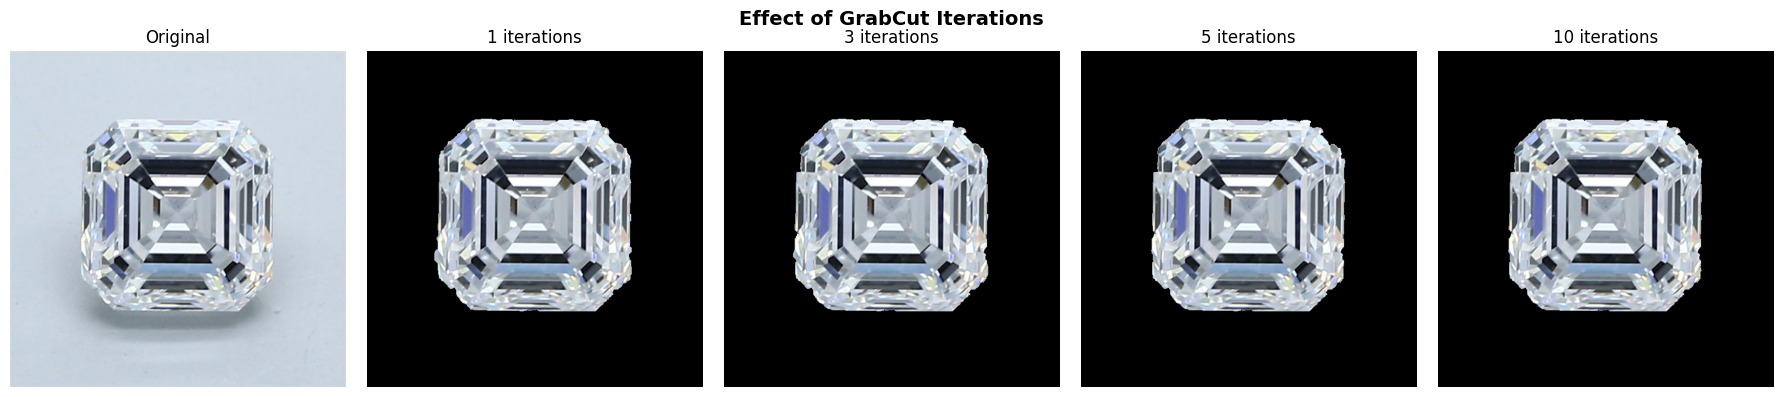

In [15]:
# Compare results with different iteration counts
test_image_path = loader.get_image_path(1, loader.list_images(1)[0])
test_image = cv2.imread(test_image_path)
orig, enh = preprocess_for_segmentation(test_image)

iteration_counts = [1, 3, 5, 10]
iteration_results = []

for iters in iteration_counts:
    seg, mask = remove_background(orig, enh, iterations=iters)
    iteration_results.append(seg)

# Display comparison
fig, axes = plt.subplots(1, len(iteration_counts) + 1, figsize=(18, 4))
fig.suptitle('Effect of GrabCut Iterations', fontsize=14, fontweight='bold')

axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

for idx, (iters, result) in enumerate(zip(iteration_counts, iteration_results), 1):
    axes[idx].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f'{iters} iterations')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 6. Performance Metrics

In [16]:
import time

# Measure processing time
test_images = loader.list_images(1)[:10]
processing_times = []

for img_name in test_images:
    img_path = loader.get_image_path(1, img_name)
    img = cv2.imread(img_path)
    
    start = time.time()
    orig, enh = preprocess_for_segmentation(img)
    seg, mask = remove_background(orig, enh, iterations=5)
    elapsed = time.time() - start
    
    processing_times.append(elapsed)

print("Performance Metrics:")
print(f"  Average time per image: {np.mean(processing_times):.3f} seconds")
print(f"  Min time: {np.min(processing_times):.3f} seconds")
print(f"  Max time: {np.max(processing_times):.3f} seconds")
print(f"  Processing speed: {1/np.mean(processing_times):.2f} images/second")

Performance Metrics:
  Average time per image: 0.926 seconds
  Min time: 0.795 seconds
  Max time: 1.013 seconds
  Processing speed: 1.08 images/second


## Summary

This notebook demonstrated:
1. Complete diamond segmentation pipeline
2. CLAHE preprocessing for enhanced contrast
3. GrabCut algorithm for background removal
4. Contour detection and bounding box annotation
5. Batch processing capabilities
6. Performance analysis

The pipeline successfully segments diamond images with high accuracy!